In [1]:
# Import packages
# Make sure you have RiverREM imported, check readme for instructions
import os
import pathlib

import matplotlib.pyplot as plt
from load_plot_model import load_dtm, plot_model, plot_hist
from riverrem.REMMaker import REMMaker, clear_osm_cache
import requests
import rioxarray as rxr

In [2]:
# Set working directory
working_dir = os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'watershed-project')

# Try/Except Block   
try:
    os.chdir(working_dir)
except:
    print('{} does not exist. Creating...'.format(working_dir))
    os.makedirs(working_dir)
    os.chdir(working_dir)
else:
    print('{} is now the working directory'.format(working_dir))

/Users/lchipman/earth-analytics/data/watershed-project is now the working directory


# Load the UAV DTMs and REMs and LiDAR DTMs

In [19]:
# Define urls to UAV DTMs and REMs (saved on zenodo)
# make into function; note when I upload the lidar urls, the crs is lost,
# so I call them locally later in code - question of elsa?
highway93_dtm_url = ('https://zenodo.org/record/8218054/files/'
                     'highway93_uav_dtm.tif?download=1')
highway93_rem_url = ('https://zenodo.org/record/8218054/files/'
                     'highway93_uav_rem.tif?download=1')
highway93_lidar_dtm_url = ('https://zenodo.org/record/8218054/files/'
                           'highway93_lidar_dtm.asc?download=1')
applevalley_dtm_url = ('https://zenodo.org/record/8218054/files/'
                       'applevalley_uav_dtm.tif?download=1')
applevalley_rem_url = ('https://zenodo.org/record/8218054/files/'
                       'applevalley_uav_rem.tif?download=1')
applevalley_lidar_dtm_url = ('https://zenodo.org/record/8218054/files/'
                             'applevalley_lidar_dtm.asc?download=1') 
hallmeadows_dtm_url = ('https://zenodo.org/record/8218054/files/'
                       'hallmeadows_uav_dtm.tif?download=1')
hallmeadows_rem_url = ('https://zenodo.org/record/8218054/files/'
                       'hallmeadows_uav_rem.tif?download=1')
hallmeadows_lidar_dtm_url = ('https://zenodo.org/record/8218054/files/'
                             'hallmeadows_lidar_dtm.asc?download=1')
# list of urls
dtm_rem_urls = [highway93_dtm_url, highway93_rem_url,highway93_lidar_dtm_url,
                applevalley_dtm_url, applevalley_rem_url,applevalley_lidar_dtm_url,
                hallmeadows_dtm_url, hallmeadows_rem_url, hallmeadows_lidar_dtm_url]

In [15]:
def store_site_info(site_names, data_url, dtm_rem_str):
        """Creates list of site info"""
        
        def load_dtm(site_name, file_name, data_url):
            """Creates DataArray of Elevation Model Data"""
            override_cache = False
            data_dir = site_name
            data_path = (os.path.join(data_dir, file_name))

            # Cache data file
            if not os.path.exists(data_dir):
                print('{} does not exist. Creating...'.format(data_dir))
                os.makedirs(data_dir)

            if (not os.path.exists(data_path)) or override_cache:
                print('{} does not exist. Downloading...'.format(data_path))
                # Download data file from url
                response = requests.get(data_url)

                # Write in respose content using context manager
                with open(data_path, 'wb') as data_file:
                    data_file.write(response.content)
            # Save the DTM as dataarray
            dtm = rxr.open_rasterio(data_path, masked=True)

            return dtm
                
        # Add site name, filename, and model data to dictionary
        site_info =[]
        for site_name in site_names:
            for dtm_rem in dtm_rem_str:
                    site_info.append({
                        'site_name': site_name,
                        'file_name': ('{}_{}').format(site_name, dtm_rem)
                    })  
        # Add rem/dtm urls to list
        for url, info in zip(data_url, site_info):
            info['data_url'] = url

        for site in site_info:
            site['model']=(
                load_dtm(data_url = site['data_url'],
                          site_name = site['site_name'],
                          file_name = site['file_name']))
        return site_info

In [18]:
# Call function to create list of dictionary with sitename, filename, and dtm/rem data 
site_names = ['highway93', 'applevalley', 'hallmeadows']
dtm_rem_str = ['dtm.tif', 'rem.tif', 'lidar_dtm.asc']
site_info = store_site_info(site_names=site_names, 
                            data_url=dtm_rem_urls, 
                            dtm_rem_str=dtm_rem_str)
#site_info

# Process LiDAR Data

In [20]:
# Set paths to LiDAR data (downloaded from CO hazard mapping)
# Saved to local drive - see note above about using link to zenodo and crs

# Directory for lidar data
lidar_dir = 'lidar_data'

# Paths to individual lidar files for each site
lidar_highway93_path = os.path.join(
    lidar_dir, 
    'lidar_highway93', 
    '3075_1760', 
    '3075_1760_elev.asc')

lidar_applevalley_path = os.path.join(
    lidar_dir, 
    'lidar_applevalley', 
    '3055_1875', 
    '3055_1875_elev.asc')

lidar_hallmeadows_path = os.path.join(
    lidar_dir, 
    'lidar_hallmeadows', 
    '3060_1865', 
    '3060_1865_elev.asc')

lidar_dtm_path_list = [lidar_highway93_path, 
                      lidar_applevalley_path, 
                      lidar_hallmeadows_path]

In [ ]:
# Process LiDAR - use this code once fix crs issue in lidar zenodo upload
#matched_lidar_dtms = []
#for site in site_info:
 #   if 'rem' in site['file_name']:
  #      rem_to_match = site['model']
        #print(site['model'].rio.crs)
   # if 'lidar' in site['file_name']:
    #    site['model'].rio.write_crs(lidar_crs)
     #   match_lidar_dtm = site['model'].rio.reproject_match(rem_to_match)
        #print(site['model'].rio.crs)

In [40]:
#Process LiDAR - use this code to process local data for now
def match_lidar(lidar_dtm_path, uav_rem_match):
    """Reproject/match lidar data using UAV REM as dataarray to match"""
    lidar_raw_dtm = rxr.open_rasterio(lidar_dtm_path, masked=True)
    lidar_match_dtm = (lidar_raw_dtm.rio.reproject_match(uav_rem_match))

    return lidar_match_dtm

In [62]:
lidar_match_dtms = []
i=0
for site in site_info:
    if 'rem' in site['file_name']:
        uav_rem_match = site['model']
        #print(site['file_name'])
        #print(lidar_dtm_path_list[i])
        lidar_match_dtms.append(match_lidar(lidar_dtm_path=lidar_dtm_path_list[i], 
                                            uav_rem_match=uav_rem_match))
        i=i+1
print(lidar_match_dtms)

[<xarray.DataArray (band: 1, y: 8836, x: 12881)>
array([[[5846.28 , 5846.28 , 5846.28 , ..., 5799.956, 5799.956,
         5799.956],
        [5846.28 , 5846.28 , 5846.28 , ..., 5799.956, 5799.956,
         5799.956],
        [5846.434, 5846.434, 5846.434, ..., 5799.956, 5799.956,
         5799.956],
        ...,
        [5818.576, 5818.576, 5818.576, ..., 5814.784, 5814.784,
         5814.784],
        [5818.576, 5818.576, 5818.576, ..., 5814.784, 5814.784,
         5814.784],
        [5818.576, 5818.576, 5818.576, ..., 5814.784, 5814.784,
         5814.784]]], dtype=float32)
Coordinates:
  * x            (x) float64 -105.2 -105.2 -105.2 ... -105.2 -105.2 -105.2
  * y            (y) float64 39.93 39.93 39.93 39.93 ... 39.92 39.92 39.92 39.92
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0, <xarray.DataArray (band: 1, y: 10950, x: 6993)>
array([[[5478.167, 5478.167, 5478.167, ..., 5465.51 , 5465.51 ,
         5465.51 ],


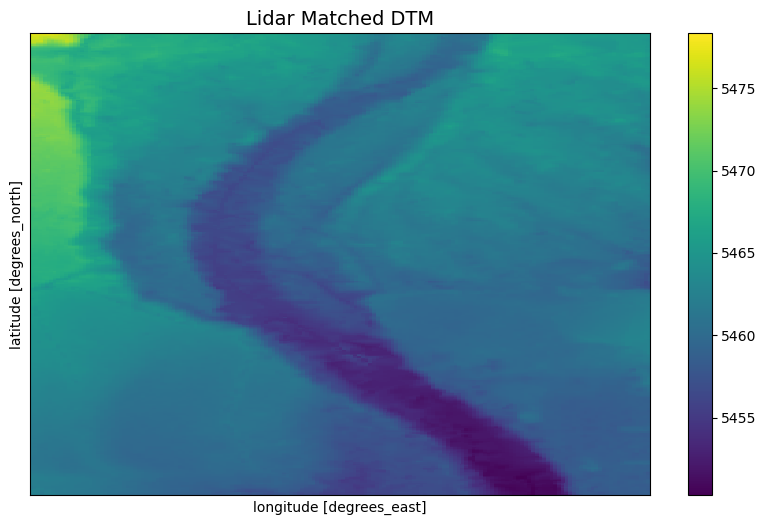

In [66]:
# is hall meadows out of bounds?
plot_model(model=lidar_match_dtms[1], title='Lidar Matched DTM', coarsen=True)
#lidar_match_dtms[1].rio.total_bounds

# Plot UAV and LiDAR DTMs

In [ ]:
# redo plot model function to loop through dtms/ax and plot each on new ax
# Move this to plot models.py
# Function to plot multiple elevation models
def plot_models(model, title, coarsen, ax):
    """
    Creates plots of multiple DTMs or REMs.
    
    Parameters
    ------------
    #row, col: int
     #   The number of rows and columns in figure.
        
    model: dataarray
        The dataarray to plot.

    title: str
        The title of the plot.
        
    coarsen: boolean
        True = coarsen data, False = do not coarsen.
    
    ax: axes
        A matplotlib axes object.

    Returns
    -------
    A plot of the elevation model with specified title.
    """

    # Hide x and y axes labels and ticks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.set_xticks([])
    ax.set_yticks([])

    # If DTM, coarsen
    if coarsen == True:
        model.coarsen(
            x=3,
            boundary='trim').mean().coarsen(
                y=3,
                boundary='trim').mean().squeeze()
    # Plot DTM
    model.plot(ax=ax)

    # Add title
    ax.set_title(title, fontsize=14)
    
    ax.legend('off')
    ax.axis('off')

In [ ]:
# Comparison plots of UAV and LiDAR DTMs
# Define plot space with x subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 6))

# List of site names to pass to function for titles
plot_titles = ('Highway 93 UAV DTM',
               'Highway 93 LiDAR DTM',
               'Apple Valley UAV DTM',
               'Apple Valley LiDAR DTM',
               'Hall Meadows UAV DTM', 
               'Hall Meadows LiDAR DTM')

# List of uav and lidar dtms to pass to plot function
all_dtm_list = [highway93_uav_dtm,
                highway93_lidar_dtm, 
                applevalley_uav_dtm,
                applevalley_lidar_dtm,
                hallmeadows_uav_dtm,
                hallmeadows_lidar_dtm]

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_models(
        model=all_dtm_list[i],
        title=plot_titles[i],
        coarsen=(True, True, True, False, False, False),
        ax=axe)

# Just the LiDAR DTM Plots

In [ ]:
# Define plot space with x subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

# List of site names to pass to function for title
plot_titles = ('Highway 93', 'Apple Valley', 'Hall Meadows')

# List of dtms to pass to function
lidar_dtm_list

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_models(
        model=lidar_dtm_list[i],
        title=plot_titles[i],
        coarsen=(False, False, False),
        ax=axe)

# Create LiDAR REMs Using REMMaker Tool

In [ ]:
def run_rem_maker(name, k=100):
    """Run the REMMaker tool"""
    
    # Input the DTM file path and desired output directory
    override_cache = False
    lidar_dtm_path = os.path.join(('LiDAR_DTM_{}.tif').format(name))
    lidar_out_path = os.path.join(lidar_dir, ('lidar_{}').format(name))
    lidar_rem_path = os.path.join(lidar_out_path, 
                                  ('LiDAR_DTM_{}_REM.tif').format(name))

    # Run the REMMaker if the path to the REM does not already exist
    if (not os.path.exists(lidar_rem_path)) or override_cache:
        rem_maker = REMMaker(dem=lidar_dtm_path, 
                             out_dir=lidar_out_path, 
                             interp_pts=1000, 
                             k=100)

        # clear OSM cache
        clear_osm_cache()

        # create an REM
        rem_maker.make_rem()

        # create an REM visualization with the given colormap
        rem_maker.make_rem_viz(cmap='mako_r')

    else:
        print('The REM already exists. Not running REMMaker')

In [ ]:
# Create REM for all sites with run_rem_maker function
site_names = ('highway93', 'applevalley', 'hallmeadows')
lidar_rem_list = []

for site in site_names:
    run_rem_maker(name=site)
    lidar_rem_path = os.path.join(lidar_dir,
                                  ('lidar_{}').format(site),
                                  ('LiDAR_DTM_{}_REM.tif').format(site))
    lidar_rem = rxr.open_rasterio(lidar_rem_path, masked=True)    
    lidar_rem_list.append(lidar_rem)

# Plot the UAV and LiDAR Derived REMs

In [ ]:
# List of REMs to pass to plot function
uav_rem_list = [highway93_uav_rem, 
                applevalley_uav_rem, 
                hallmeadows_uav_rem]

# New list to arrange order for plots

all_rem_list = [highway93_uav_rem, lidar_rem_list[0],
                applevalley_uav_rem, lidar_rem_list[1],
                hallmeadows_uav_rem, lidar_rem_list[2]]

In [ ]:
# Plot the REMs - just lidar, kernal dies when I try to plot UAV also
# Define plot space with x subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 16))

# List of site names to pass to function for titles
plot_title = ('LiDAR-Derived REM for Highway 93',
              'LiDAR-Derived REM for Apple Valley',
              'LiDAR-Derived REM for Hall Meadows')

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_models(
        model=lidar_rem_list[i],
        title=plot_title[i],
        coarsen=(False, False, False),
        ax=axe)
# Note - I increased value of k in the REMMAker and streaking improved!!
# "param k: number of nearest neighbors to use for IDW interpolation. If None, an appropriate value is estimated.
#  The estimation routine uses k between 5-100 points (0.5-10% of the river length) depending on the
#  sinuosity of the river of interest. Greater values of k are used for more sinuous rivers.""

In [ ]:
# Call function to plot histogram of REMs
# Plot the REMs
# Define plot space with x subplots
#fig, axes = plt.subplots(3, 2, figsize=(12, 14))

# List of site names to pass to function for titles
plot_title = ('Histogram UAV-Derived REM for Highway 93',
              'Histogram LiDAR-Derived REM for Highway 93',
              'Histogram UAV-Derived REM for Apple Valley', 
              'Histogram LiDAR-Derived REM for Apple Valley',
              'Histogram UAV-Derived REM for Hall Meadows',
              'Histogram LiDAR-Derived REM for Hall Meadows')

# Call plot function
for i, axe in enumerate(axes.flatten()):
    plot_hist(
        model=all_rem_list[i],
        title=plot_title[i],
        color='cyan')

In [ ]:
all_rem_list = [highway93_uav_rem, lidar_rem_list[0],
                applevalley_uav_rem, lidar_rem_list[1],
                hallmeadows_uav_rem, lidar_rem_list[2]]

In [ ]:
#'Histogram UAV-Derived REM for Highway 93'
highway93_uav_rem.plot.hist();

In [ ]:
#'Histogram LiDAR-Derived REM for Highway 93'
lidar_rem_list[0].plot.hist();

In [ ]:
#'Histogram UAV-Derived REM for Apple Valley'
applevalley_uav_rem.plot.hist(color='green');

In [ ]:
#'Histogram LiDAR-Derived REM for Apple Valley'
lidar_rem_list[1].plot.hist(color='green');

In [ ]:
#'Histogram UAV-Derived REM for Hall Meadows'
hallmeadows_uav_rem.plot.hist(color='cyan');

In [ ]:
#'Histogram LiDAR-Derived REM for Hall Meadows'
lidar_rem_list[2].plot.hist(color='cyan');